# 종합 통계 실습

## 비즈니스 시나리오

> 여러분은 식품·와인 유통 기업 **FreshCart**의 데이터 분석팀 인턴입니다. \
> 마케팅팀이 6차례 캠페인을 진행했지만 수락률이 낮아 경영진이 우려하고 있습니다. \
> 고객 데이터를 분석하여 **다음 캠페인의 집중 공략 전략**을 수립해 주세요.

---

| Part | 주제 | 핵심 질문 |
|------|------|-----------|
| **Part 0** | 데이터 전처리 | (코드 제공) |
| **Part 1** | 탐색적 데이터 분석 | 고객은 누구인가? |
| **Part 2** | 확률분포 모델링 | 고객 행동은 어떤 패턴을 따르는가? |
| **Part 3** | 추정과 가설검정 | 고소득 고객과 저소득 고객의 소비는 다른가? |
| **Part 4** | 고급 검정 | 교육, 결혼, 캠페인 반응의 관계는? |
| **Part 5** | 상관분석 / 비율 비교 | 변수 간 관계를 파악하고, 캠페인 효과를 검증할 수 있는가? |
| **Challenge** | 종합 분석 보고서 | 다음 캠페인 타겟은 누구인가? |

### 데이터 셋 개요

| 항목 | 내용 |
|------|------|
| **출처** | Kaggle |
| **URL** | https://www.kaggle.com/datasets/imakash3011/customer-personality-analysis |
| **크기** | 약 2,240행 × 29열 |
| **파일명** | `marketing_campaign.csv` |
| **도메인** | 식품·와인 유통 기업 |

**설명:** 고객 성격 분석은 기업의 이상적인 고객을 심층 분석하는 방법론이다. 고객 세그먼트별 니즈·행동·관심사를 파악해 제품 및 마케팅을 최적화하는 데 활용한다.

---

### 변수 목록

#### 고객 정보

| # | 변수명 | 설명 |
|---|--------|------|
| 1 | `ID` | 고객 고유 식별자 |
| 2 | `Year_Birth` | 고객 출생연도 |
| 3 | `Education` | 최종 학력 |
| 4 | `Marital_Status` | 결혼 상태 |
| 5 | `Income` | 연간 가구 소득 |
| 6 | `Kidhome` | 가구 내 어린 자녀 수 |
| 7 | `Teenhome` | 가구 내 십대 자녀 수 |
| 8 | `Dt_Customer` | 고객 등록일 |
| 9 | `Recency` | 마지막 구매 이후 경과 일수 |

---

#### 소비 패턴 — 최근 2년간 지출 금액

| # | 변수명 | 설명 |
|---|--------|------|
| 10 | `MntWines` | 와인 지출 금액 |
| 11 | `MntFruits` | 과일 지출 금액 |
| 12 | `MntMeatProducts` | 육류 지출 금액 |
| 13 | `MntFishProducts` | 생선 지출 금액 |
| 14 | `MntSweetProducts` | 과자·디저트 지출 금액 |
| 15 | `MntGoldProds` | 골드 지출 금액 |

---

#### 캠페인 반응

| # | 변수명 | 설명 |
|---|--------|------|
| 16 | `NumDealsPurchases` | 할인 적용 구매 횟수 |
| 17 | `NumWebPurchases` | 웹사이트를 통한 구매 횟수 |
| 18 | `NumCatalogPurchases` | 카탈로그를 통한 구매 횟수 |
| 19 | `NumStorePurchases` | 오프라인 매장 구매 횟수 |
| 20 | `NumWebVisitsMonth` | 최근 한 달간 웹사이트 방문 횟수 |
| 21 | `AcceptedCmp3` | 3차 캠페인 제안 수락 여부 (1=수락, 0=거절) |
| 22 | `AcceptedCmp4` | 4차 캠페인 제안 수락 여부 |
| 23 | `AcceptedCmp5` | 5차 캠페인 제안 수락 여부 |
| 24 | `AcceptedCmp1` | 1차 캠페인 제안 수락 여부 |
| 25 | `AcceptedCmp2` | 2차 캠페인 제안 수락 여부 |
| 26 | `Complain` | 최근 2년 내 불만 제기 여부 (1=있음, 0=없음) |
| 27 | `Z_CostContact` | 상수값 3 — 캠페인 1회당 연락 비용 |
| 28 | `Z_Revenue` | 상수값 11 — 캠페인 성공 시 수익 |
| 29 | `Response` | 최종 캠페인 제안 수락 여부 **(타깃 변수)** |

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import trim_mean
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.proportion import (
    proportions_ztest, proportion_confint, proportion_effectsize
)
from statsmodels.stats.power import NormalIndPower, TTestIndPower
import pingouin as pg
import warnings
import platform

warnings.filterwarnings('ignore')

if platform.system() == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'
elif platform.system() == 'Darwin':
    plt.rcParams['font.family'] = 'AppleGothic'
else:
    plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

COLORS = {
    'blue': '#3B82F6', 'indigo': '#6366F1', 'violet': '#8B5CF6',
    'teal': '#14B8A6', 'emerald': '#10B981', 'amber': '#F59E0B',
    'rose': '#F43F5E', 'red': '#EF4444', 'slate': '#64748B',
    'sky': '#0EA5E9', 'purple': '#A855F7', 'lime': '#84CC16',
}

---
## Part 0: 데이터 전처리 (코드 제공)

아래 코드를 실행하여 분석에 사용할 데이터프레임 `df`를 준비합니다.
모든 파생변수가 생성되고 이상치가 제거된 상태에서 Part 1부터 분석을 시작합니다.

### 0-1. 데이터 로드 및 결측치 처리

In [2]:
df = pd.read_csv('data/marketing_campaign.csv', sep='\t')
print(f"원본 데이터: {df.shape[0]}행 × {df.shape[1]}열")
print(f"Income 결측치: {df['Income'].isnull().sum()}개")

df['Income'] = df['Income'].fillna(df['Income'].median())
print(f"→ Income 중앙값({df['Income'].median():,.0f})으로 대치 완료")

원본 데이터: 2240행 × 29열
Income 결측치: 24개
→ Income 중앙값(51,382)으로 대치 완료


In [3]:
df = pd.read_csv('data/marketing_campaign.csv', sep = '\t')
print(f'원본 데이터: {df.shape[0]}행 x {df.shape[1]}열')
print(f'Income 결측치: {df['Income'].isnull().sum()}개')

df['Income'] = df['Income'].fillna(df['Income'].median())
print(f' -> Income 중앙값({df['Income'].median():,.0f})으로 대치 완료')

원본 데이터: 2240행 x 29열
Income 결측치: 24개
 -> Income 중앙값(51,382)으로 대치 완료


### 0-2. 파생변수 생성

In [4]:
spending_cols = ['MntWines', 'MntFruits', 'MntMeatProducts',
                'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']
purchase_cols = ['NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases']
campaign_cols = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3',
                'AcceptedCmp4', 'AcceptedCmp5', 'Response']

df['Age'] = 2024 - df['Year_Birth']
df['Total_Spending'] = df[spending_cols].sum(axis=1)
df['Total_Purchases'] = df[purchase_cols].sum(axis=1)
df['Total_Accepted'] = df[campaign_cols].sum(axis=1)
df['Has_Children'] = (df['Kidhome'] + df['Teenhome']) > 0
df['Income_Group'] = pd.qcut(df['Income'], 3, labels=['Low', 'Mid', 'High'])

bins = [0, 39, 49, 59, 200]
labels_age = ['30대 이하', '40대', '50대', '60대 이상']
df['Age_Group'] = pd.cut(df['Age'], bins=bins, labels=labels_age)

edu_map = {'Basic': 'Undergraduate', '2n Cycle': 'Undergraduate',
        'Graduation': 'Graduate', 'Master': 'Postgraduate', 'PhD': 'Postgraduate'}
df['Education_Group'] = df['Education'].map(edu_map)

marital_map = {'Married': 'Together', 'Together': 'Together',
        'Single': 'Single', 'Divorced': 'Single', 'Widow': 'Single',
        'Alone': 'Single', 'Absurd': 'Single', 'YOLO': 'Single'}
df['Marital_Group'] = df['Marital_Status'].map(marital_map)

df['Campaign_Response'] = df['Total_Accepted'] > 0

df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format='%d-%m-%Y')
reference_date = df['Dt_Customer'].max()
df['Customer_Days'] = (reference_date - df['Dt_Customer']).dt.days

print("파생변수 생성 완료:")
for col in ['Age', 'Total_Spending', 'Total_Purchases', 'Total_Accepted',
        'Has_Children', 'Income_Group', 'Age_Group', 'Education_Group',
        'Marital_Group', 'Campaign_Response', 'Customer_Days']:
        print(f"  - {col}: {df[col].dtype}")

파생변수 생성 완료:
  - Age: int64
  - Total_Spending: int64
  - Total_Purchases: int64
  - Total_Accepted: int64
  - Has_Children: bool
  - Income_Group: category
  - Age_Group: category
  - Education_Group: str
  - Marital_Group: str
  - Campaign_Response: bool
  - Customer_Days: int64


### 0-3. 이상치 제거

In [5]:
n_before = len(df)
df = df[(df['Age'] <= 100) & (df['Income'] <= 200000)].copy()
n_after = len(df)
print(f"이상치 제거: {n_before}행 → {n_after}행 ({n_before - n_after}행 제거)")
print(f"\n최종 데이터 요약:")
print(f"  Age 범위: {df['Age'].min()} ~ {df['Age'].max()}")
print(f"  Income 범위: {df['Income'].min():,.0f} ~ {df['Income'].max():,.0f}")
print(f"\n데이터 준비가 완료되었습니다. Part 1부터 분석을 시작하세요!")

이상치 제거: 2240행 → 2236행 (4행 제거)

최종 데이터 요약:
  Age 범위: 28 ~ 84
  Income 범위: 1,730 ~ 162,397

데이터 준비가 완료되었습니다. Part 1부터 분석을 시작하세요!


---
## Part 1: 탐색적 데이터 분석 — "고객은 누구인가?"

기술통계량과 시각화를 통해 FreshCart 고객의 특성을 파악합니다.

### 문제 1-1. 중심경향과 산포도

`Income`, `Total_Spending`, `Age` 세 변수에 대해 다음을 계산하세요.

| 중심경향 | 산포도 |
|----------|--------|
| 평균(mean) | 분산(variance) |
| 중앙값(median) | 표준편차(std) |
| 최빈값(mode) | 사분위범위(IQR) |
| 5% 절사평균(trimmed mean) | 변동계수(CV) |

In [6]:
# TODO 1-1(a): Income, Total_Spending, Age의 중심경향 — 평균, 중앙값, 최빈값, 5% 절사평균

location_stat = df[['Income','Total_Spending','Age']].agg(['mean','median', lambda x: x.mode().iloc[0], lambda x: trim_mean(x, 0.05)]).T
location_stat.columns = ['평균','중앙값','최빈값','5% 절사평균']

display(location_stat)

,평균,중앙값,최빈값,5% 절사평균
Income,51952.614043,51381.5,51381.5,51740.153426
Total_Spending,605.986583,396.5,46.0,561.119662
Age,55.101968,54.0,48.0,55.074975


In [7]:
# TODO 1-1(b): Income, Total_Spending, Age의 산포도 — 분산(ddof=1), 표준편차, IQR, CV(%)

scale_stat = df[['Income','Total_Spending','Age']].agg(
    [lambda x: x.var(ddof = 1),
    lambda x: x.std(ddof = 1),
    lambda x: x.quantile(0.75) - x.quantile(0.25),
    lambda x: x.std(ddof = 1) / x.mean() * 100
    ]
).T

scale_stat.columns = ['분산','표준편차','IQR','CV(%)']
display(scale_stat)

,분산,표준편차,IQR,CV(%)
Income,4.584509e+08,21411.466851,32773.25,41.213454
Total_Spending,3.622417e+05,601.865156,976.50,99.319881
Age,1.369668e+02,11.703281,18.00,21.239315


### 문제 1-2. 분포 시각화

- **(a)** Income 히스토그램 + KDE + 평균/중앙값 수직선
- **(b)** Total_Spending 수평 박스플롯 + IQR 기준 이상치 개수 출력
- **(c)** Income_Group별 Total_Spending 바이올린 플롯

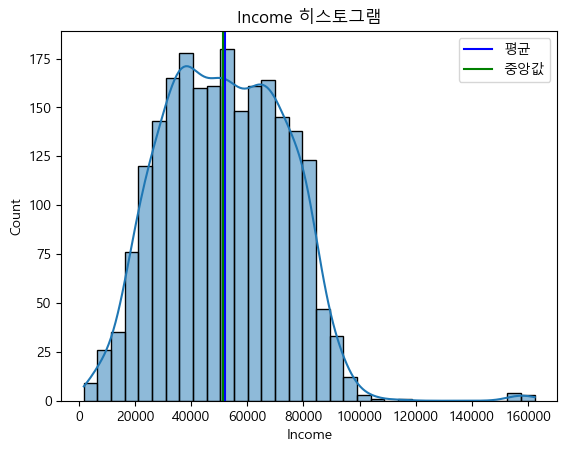

In [8]:
# TODO 1-2(a): Income 히스토그램 + KDE

fig, ax = plt.subplots(1,1)

sns.histplot(df['Income'], kde = True, ax = ax)
ax.axvline(df['Income'].mean(), color = 'blue', label = '평균')
ax.axvline(df['Income'].median(), color = 'green', label = '중앙값')

plt.title('Income 히스토그램')
plt.legend()
plt.show()

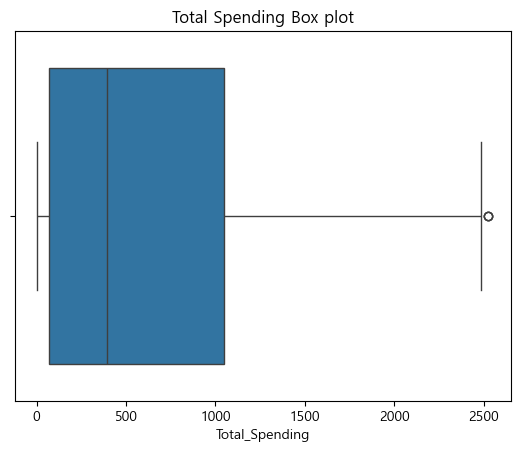

iqr 하한 : -1395.75, iqr 상한 : 2510.25
이상치 개수 : 3


In [9]:
# TODO 1-2(b): Total_Spending 박스플롯 + IQR 기준 이상치

fig, ax = plt.subplots(1,1)

sns.boxplot(df['Total_Spending'], orient = 'h')
plt.title('Total Spending Box plot')
plt.show()

q1 = df['Total_Spending'].quantile(0.25)
q3 = df['Total_Spending'].quantile(0.75)
iqr = q3 - q1
lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr

print(f'iqr 하한 : {lower}, iqr 상한 : {upper}')
cond = (df['Total_Spending'] > q3 + 1.5 * iqr) | (df['Total_Spending'] < q1 - 1.5 * iqr)
print(f'이상치 개수 : {len(df[cond])}')

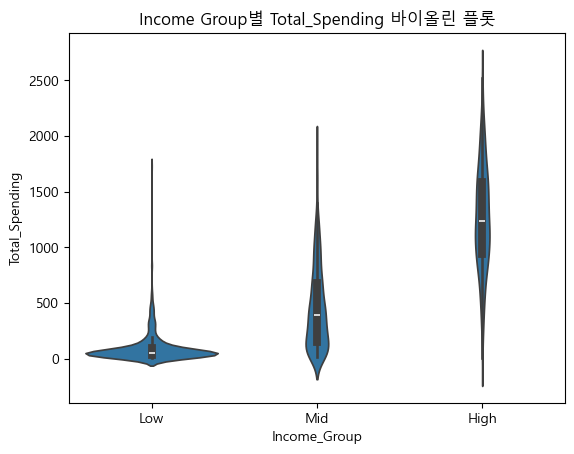

In [10]:
# TODO 1-2(c): Income_Group별 Total_Spending 바이올린 플롯
sns.violinplot(data = df, x = 'Income_Group', y = 'Total_Spending')
plt.title('Income Group별 Total_Spending 바이올린 플롯')
plt.show()

### 문제 1-3. 왜도와 첨도

6개 소비 카테고리(MntWines ~ MntGoldProds)의 왜도(Skewness)와 첨도(Kurtosis)를 계산하고,
2×3 히스토그램 그리드를 그려 분포 형태를 비교하세요.

**왜도 해석**
- 왜도 > 0: 오른쪽 꼬리가 긴 분포 
- 왜도 < 0: 왼쪽 꼬리가 긴 분포 
- 왜도 ≈ 0: 좌우 대칭에 가까운 분포

**첨도 해석** 
- 초과 첨도 > 0: 정규분포보다 중앙이 뾰족하고 꼬리가 두꺼운 분포 
- 초과 첨도 < 0: 정규분포보다 중앙이 평평하고 꼬리가 얇은 분포
- 초과 첨도 ≈ 0: 정규분포와 유사한 형태

In [11]:
spending_names = ['MntWines','MntFruits','MntMeatProducts','MntFishProducts','MntSweetProducts','MntGoldProds']
hist_colors = [COLORS['blue'], COLORS['violet'], COLORS['teal'],
            COLORS['emerald'], COLORS['amber'], COLORS['rose']]

# TODO 1-3(a): 6개 카테고리의 왜도/첨도 계산 및 출력

df[spending_names].agg(['skew','kurt']).T

,skew,kurt
MntWines,1.176036,0.600531
MntFruits,2.104241,4.069754
MntMeatProducts,2.085282,5.530136
MntFishProducts,1.919970,3.096020
MntSweetProducts,2.135674,4.372062
MntGoldProds,1.885136,3.558349


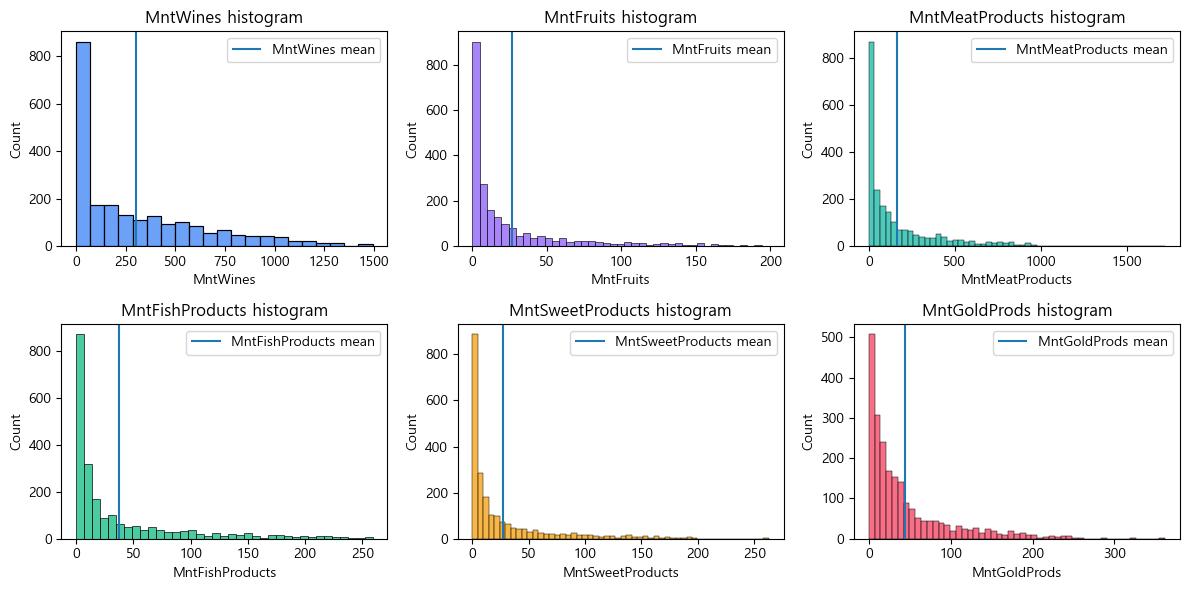

In [12]:
# TODO 1-3(b): 2×3 히스토그램 그리드 (각 카테고리 분포 + 평균선)

fig, axs = plt.subplots(2,3, figsize = (12,6))

for i, name in enumerate(spending_names):
    x = i // 3
    y = i % 3
    sns.histplot(df[name], ax = axs[x][y], color = hist_colors[i])
    axs[x][y].set_title(f'{name} histogram')
    axs[x][y].axvline(df[name].mean(), label = f'{name} mean')
    axs[x][y].legend()

plt.tight_layout()
plt.show()

### 문제 1-4. 비즈니스 인사이트 정리

Part 1의 분석 결과를 바탕으로 다음을 정리하세요.

1. 고객 특성 요약 (연령, 소득, 소비 특성)
2. 핵심 발견 사항 (분포 특성, 그룹 간 차이)
3. 후속 분석에서 검증할 가설 (최소 3개)

In [13]:
# TODO 1-4: 비즈니스 인사이트 정리

print('1. 고객 특성 요약')

print('고객들의 소득의 평균은 약 51952$이고, 나이의 평균은 약 55세이다.')
print('소비의 경우 평균과 중앙값, 최빈값을 고려했을 때 오른쪽 꼬리 긴 분포를 가진다.')
print('따라서, 소비의 중앙값으로 중심 측도를 보면 대략 606$이다.')
print('변동계수가 99%로 Total_Spending은 변동폭이 매우 크다는 것을 알 수 있다.')

print('2. 핵심 발견 사항')
print('소득의 경우 일부 160,000에 기록되어있는 극단값을 제외하면, 분포가 정규분포를 띄는 것 처럼 보인다.')
print('소비 특성은 오른쪽 꼬리가 긴 분포를 보인다.')
print('또한 소득 그룹별로 소비의 차이가 존재하는 것처럼 보인다.')

print('3. 후속 분석에서 검증할 가설')
print('1.1 고객들의 소득의 분포는 정규분포를 따르는가')
print('1.2 극단값을 제외했을 경우 소득의 분포는 정규분포를 따르는가')
print('2 소득 그룹별로 소비의 차이가 존재하는가')
print('3. 소득과 소비는 상관성이 있는가')

1. 고객 특성 요약
고객들의 소득의 평균은 약 51952$이고, 나이의 평균은 약 55세이다.
소비의 경우 평균과 중앙값, 최빈값을 고려했을 때 오른쪽 꼬리 긴 분포를 가진다.
따라서, 소비의 중앙값으로 중심 측도를 보면 대략 606$이다.
변동계수가 99%로 Total_Spending은 변동폭이 매우 크다는 것을 알 수 있다.
2. 핵심 발견 사항
소득의 경우 일부 160,000에 기록되어있는 극단값을 제외하면, 분포가 정규분포를 띄는 것 처럼 보인다.
소비 특성은 오른쪽 꼬리가 긴 분포를 보인다.
또한 소득 그룹별로 소비의 차이가 존재하는 것처럼 보인다.
3. 후속 분석에서 검증할 가설
1.1 고객들의 소득의 분포는 정규분포를 따르는가
1.2 극단값을 제외했을 경우 소득의 분포는 정규분포를 따르는가
2 소득 그룹별로 소비의 차이가 존재하는가
3. 소득과 소비는 상관성이 있는가


---
## Part 2: 확률분포 모델링 — "고객 행동은 어떤 패턴을 따르는가?"

실제 고객 데이터에 이론적 확률분포를 적합하여 고객 행동을 모델링합니다.

### 문제 2-1. 이항분포 — 캠페인 수락 모델링

`Response` 열에서 수락률 p를 계산하고, 이를 이항분포 B(n, p)에 적용합니다.

- **(a)** 10명 중 정확히 2명이 수락할 확률
  - B(n=10, p) 에서 P(X = 2) 계산

- **(b)** 10명 중 3명 이상이 수락할 확률
  - B(n=10, p) 에서 P(X ≥ 3) 계산

- **(c)** 이항분포 PMF 시각화
  - B(n=10, p) 의 모든 경우(X = 0, 1, ..., 10)에 대한
    이론 확률을 막대그래프로 그립니다.

- **(d)** n=100 으로 확장 — 세 가지 질문
  - **기대 수락자 수**: E(X) 계산
  - **15명 이상 수락 확률**: P(X ≥ 15) 계산
  - **90% 보장 최소 수락 수**: P(X ≤ k) ≥ 0.90 을 만족하는 최솟값 k 탐색

In [14]:
# TODO 2-1(a),(b): 수락률(p) 계산 + P(X=2), P(X≥3) 계산 및 출력
n_trial = 10
p = sum(df['Response']) / len(df['Response'])

print(f'수락률 : {p:.4f}')

binom_dist = stats.binom(n_trial, p)

print(f'P(X = 2) = {binom_dist.pmf(2):.4f}')
print(f'P(X >= 3) = {1 - binom_dist.cdf(2):.4f}')

수락률 : 0.1494
P(X = 2) = 0.2752
P(X >= 3) = 0.1782


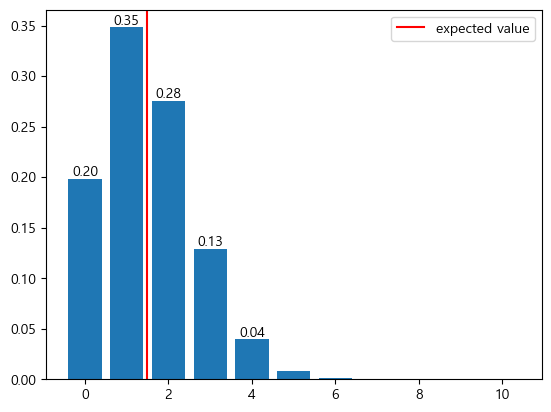

In [15]:
# TODO 2-1(c): 이항분포 PMF 시각화

x_arr = np.arange(0,11,1)
y_arr = [binom_dist.pmf(x).item() for x in x_arr]

plt.bar(x_arr, y_arr)
plt.axvline(n_trial * p, color = 'red', label = 'expected value')

for x, prob in zip(x_arr, y_arr):
    if prob > 0.01:
        plt.text(x, prob + 0.003, f'{prob:.2f}', ha = 'center')

plt.legend()
plt.show()

In [16]:
# TODO 2-1(d): 100명 발송 시 기대 수락자, P(X≥15), 90% 보장 최소 수락 수
n_campaign = 100

print(f'기대 수락자 : {n_campaign * p:.2f}명')

binom_dist = stats.binom(n_campaign, p)

print(f'P(X >= 15) : {1 - binom_dist.cdf(14):.4f}')

print(f'90% 보장 최소 수락 수 : {binom_dist.ppf(0.1)}')

기대 수락자 : 14.94명
P(X >= 15) : 0.5358
90% 보장 최소 수락 수 : 10.0


### 문제 2-2. 포아송 분포 — 웹사이트 방문 모델링

`NumWebVisitsMonth`(월간 웹 방문 수)에 포아송 분포를 적합합니다.

- **(a)** λ 추정 및 적합 평가
  - 표본 평균으로 λ를 추정하고,
    표본 평균 ≈ 표본 분산인지 확인하여 포아송 분포 적합 여부를 평가합니다.

- **(b)** 실측 vs 이론 PMF 시각화
  - 각 방문 횟수(0회, 1회, 2회, ...)별 실제 비율(실측 PMF)과
    포아송 분포의 이론 확률(이론 PMF)을 막대그래프로 겹쳐 그려 비교합니다.

- **(c)** 포아송 분포 활용 — 두 가지 실무 시나리오
  - **과다 방문 고객 비율**: P(X ≥ 10) 계산
    → 추정된 포아송 분포에서 월 10회 이상 방문할 확률이 몇 %인지 구합니다.
  - **서버 용량 계획**: 상위 5% 기준값 k 계산, 즉 P(X ≤ k) = 0.95 를 만족하는 k 탐색
    → 전체 고객의 95%를 커버할 수 있는 최대 방문 횟수를 구하고,
       이를 서버가 처리해야 할 기준 용량으로 활용합니다.

In [17]:
# TODO 2-2(a): 람다 추정 및 포아송 적합 평가 (월간 웹 방문수 평균≈분산 값이 비슷한지 확인)
web_visits = df['NumWebVisitsMonth']
print(f'웹 방문 수 평균 : {web_visits.mean():.4f}')
print(f'웹 방문 수 분산 : {web_visits.var():.4f}')

print('웹 방문수의 평균과 분산이 비슷한 것으로 보아, 해당 분포는 포아송 분포일 것으로 예상된다.')

poi_lambda = web_visits.mean()
poisson_dist = stats.poisson(poi_lambda)

웹 방문 수 평균 : 5.3189
웹 방문 수 분산 : 5.8898
웹 방문수의 평균과 분산이 비슷한 것으로 보아, 해당 분포는 포아송 분포일 것으로 예상된다.


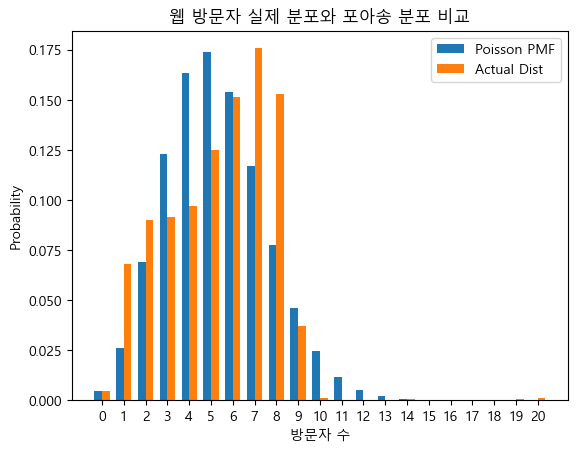

In [18]:
# TODO 2-2(b): 월간 웹 방문수 막대그래프 vs 이론 PMF 비교 시각화 (두 그래프를 겹쳐서 그리기)

fig, ax = plt.subplots(1,1)

x_arr = np.arange(0, web_visits.max() + 1)
y_arr = [poisson_dist.pmf(x).item() for x in x_arr]
y_actual = web_visits.value_counts(normalize = True).reindex(x_arr, fill_value = 0)

width = 0.35

ax.bar(x_arr - width / 2, y_arr, width, label = 'Poisson PMF')
ax.bar(x_arr + width / 2, y_actual, width, label = 'Actual Dist')

ax.set_xticks(x_arr)
ax.set_title('웹 방문자 실제 분포와 포아송 분포 비교')
ax.set_xlabel('방문자 수')
ax.set_ylabel('Probability')
ax.legend()

plt.show()

In [19]:
# TODO 2-2(c):
# - 과다 방문 고객: 포아송 분포로 P(X ≥ 10) 계산 (월 10회 이상 방문 확률)
# - 서버 용량 계획: P(X ≤ k) ≥ 0.95 를 만족하는 최솟값 k 탐색 (상위 5% 기준)
heavy_threshold = 10

print(f'P(X >= 10) = {1 - poisson_dist.cdf(9):.4f}')
print(f'P(X <= K) >= 0.95, K = {poisson_dist.ppf(0.95)}')

P(X >= 10) = 0.0449
P(X <= K) >= 0.95, K = 9.0


### 문제 2-3. 정규분포 — 소득 모델링

`Income`에 정규분포를 적합합니다.
Part 1에서 Income의 왜도가 작고 평균≈중앙값임을 확인했습니다. 정규분포가 잘 맞을까요?

- **(a)** μ, σ 추정 후 CDF로 P(Income < 30000), P(Income > 80000) 계산,
 PPF로 상위 10% 소득 기준값 계산 — **이론 확률과 실측 비율을 비교**하세요
- **(b)** 히스토그램 + 정규 분포 PDF와 겹쳐 그리기
- **(c)** 정규분포 활용 — 두 가지 질문
  - **VIP 기준선**: 상위 5% 소득 기준값
    → "이 금액 이상이면 VIP 고객으로 분류"
  - **할인 대상 기준선**: 하위 10% 소득 기준값
    → "이 금액 이하이면 할인 대상 고객으로 분류"


In [20]:
# TODO 2-3(a): μ, σ 추정 → CDF로 P(Income<30000), P(Income>80000) 계산
#               PPF로 상위 10% 소득 기준값 계산 → 이론 확률과 실측 비율 비교

xbar = df['Income'].mean()
std = df['Income'].std()

norm_dist = stats.norm(loc = xbar, scale = std)

print(f'P(Income < 30000)')
print(f'이론적 확률 : {norm_dist.cdf(30000):.4f}')
print(f'실측 비율 : {sum(df['Income'] < 30000) / len(df):.4f}\n')

print(f'P(Income > 80000)')
print(f'이론적 확률 : {1 - norm_dist.cdf(80000):.4f}')
print(f'실측 비율 : {sum(df['Income'] > 80000) / len(df):.4f}\n')

print('소득 상위 10% 기준 값')
print(f'이론적 확률 : {norm_dist.ppf(0.9):.4f}')
print(f'실측 비율 : {df['Income'].quantile(0.9)}')

P(Income < 30000)
이론적 확률 : 0.1526
실측 비율 : 0.1655

P(Income > 80000)
이론적 확률 : 0.0951
실측 비율 : 0.0962

소득 상위 10% 기준 값
이론적 확률 : 79392.5129
실측 비율 : 79747.5


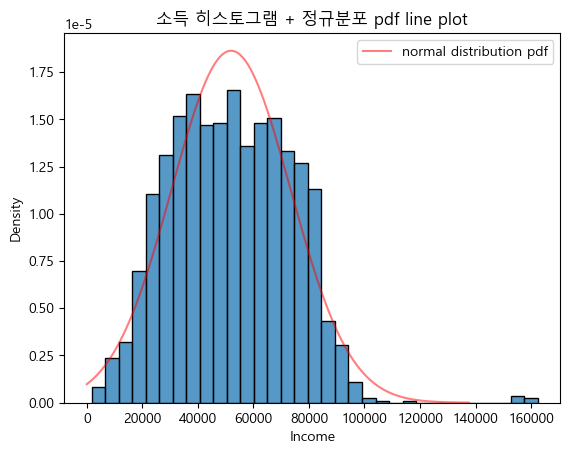

In [21]:
# TODO 2-3(b): 히스토그램 + 정규 PDF 겹쳐 그리기

fig, ax = plt.subplots(1,1)

sns.histplot(df['Income'], ax = ax, stat = 'density')

x_m = np.linspace(0, xbar + 4 * std, 1000)
y_m = norm_dist.pdf(x_m)
ax.plot(x_m, y_m, alpha = 0.5, color = 'red', label = 'normal distribution pdf')

plt.title('소득 히스토그램 + 정규분포 pdf line plot')
plt.legend()
plt.show()

In [22]:
# TODO 2-3(c): 실무 시나리오 — VIP(상위 5%) 기준선 + 할인 대상(하위 10%) 기준선

print(f'VIP(상위 5%) 기준선 : {norm_dist.ppf(0.95):.4f}')
print(f'할인 대상(하위 10%) 기준선 : {norm_dist.ppf(0.10):.4f}')

VIP(상위 5%) 기준선 : 87171.3430
할인 대상(하위 10%) 기준선 : 24512.7152


---
## Part 3: 추정과 가설검정 — "고소득 고객과 저소득 고객의 소비는 다른가?"

신뢰구간과 가설검정을 통해 고객 그룹 간 차이를 통계적으로 검증합니다.

### 문제 3-1. 신뢰구간 추정

- **(a)** Total_Spending 평균의 90%, 95%, 99% 신뢰구간을 계산하세요.
- **(b)** Income_Group별 95% CI를 계산하고 오차막대 그래프로 비교하세요.

CI = [x̄ - t × SE, x̄ + t × SE] (SE = s / √n)

In [23]:
# TODO 3-1(a): Total_Spending 평균의 신뢰구간 (90%, 95%, 99%)
# CI = x̄ ± t(α/2, n-1) × SE

location = df['Total_Spending'].mean()
se_df = df['Total_Spending'].std(ddof = 1) / np.sqrt(len(df))
dof = len(df) - 1

ci_list = []

for conf in [0.90,0.95,0.99]:
    ci_lower, ci_upper = stats.t.interval(conf, df = dof, loc = location, scale = se_df)
    ci_list.append([ci_lower.item(), ci_upper.item()])

ci_df = pd.DataFrame(ci_list, index = [0.90, 0.95, 0.99], columns = ['ci_low','ci_upp'])
display(ci_df)

,ci_low,ci_upp
0.90,585.042054,626.931113
0.95,581.026464,630.946702
0.99,573.173169,638.799997


,Group,Mean,Sem,CI_Lower,CI_Upper
0,Low,95.676944,4.555306,86.734180,104.619707
1,Mid,457.930201,13.477225,431.472284,484.388119
2,High,1265.037584,17.159656,1231.350475,1298.724693


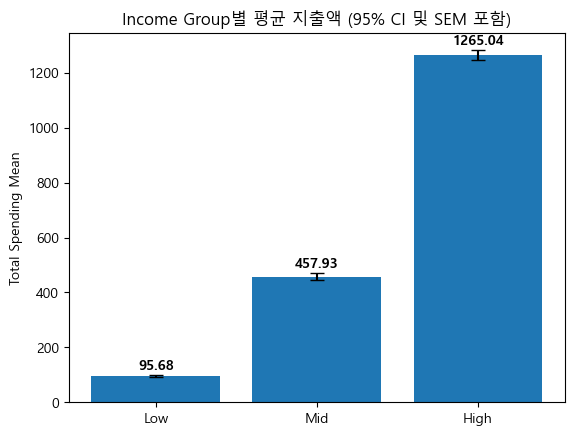

In [24]:
# TODO 3-1(b): Income_Group별 95% CI 계산 + 오차막대 그래프

def group_ci(df, group, col, conf = 0.95):
    group_val = df[group].unique()

    results = []

    for g in group_val:
        group_df = df[df[group] == g]
        group_mean = group_df[col].mean()
        group_se = stats.sem(group_df[col])
        dof = len(group_df)
        ci_low, ci_upp = stats.t.interval(conf, df = dof - 1, loc = group_mean, scale = group_se)
        results.append({
            'Group': g,
            'Mean': group_mean,
            'Sem':group_se,
            'CI_Lower': ci_low,
            'CI_Upper': ci_upp
        })
    
    return pd.DataFrame(results)

group_ci_df = group_ci(df, 'Income_Group', 'Total_Spending').sort_values('Mean').reset_index(drop = True)
display(group_ci_df)

fig, ax = plt.subplots(1,1)

ax.bar(data = group_ci_df, x = 'Group', height = 'Mean', yerr = 'Sem',
    capsize = 5)

for i, row in group_ci_df.reset_index().iterrows():
    ax.text(i,                         # x축 위치 (0, 1, 2...)
            row['Mean'] + row['Sem'] + 10, # y축 위치 (평균 + 오차보다 조금 위)
            f"{row['Mean']:.2f}",      # 표시할 텍스트
            ha='center',               # 가로 정렬: 중앙
            va='bottom',               # 세로 정렬: 하단 기준
            fontweight='bold')

ax.set_title('Income Group별 평균 지출액 (95% CI 및 SEM 포함)')
ax.set_ylabel('Total Spending Mean')
plt.show()

### 문제 3-2. 독립표본 t-검정 (Welch's t-test)

**가설**: 자녀가 없는 고객의 총 소비가 자녀가 있는 고객과 다른가?

- H₀: μ_무자녀 = μ_유자녀
- H₁: μ_무자녀 ≠ μ_유자녀

Cohen's d 해석 기준: |d| < 0.5 작은, 0.5~0.8 중간, > 0.8 큰 효과

In [25]:
no_child = df[~df['Has_Children']]['Total_Spending']
yes_child = df[df['Has_Children']]['Total_Spending']

# TODO 3-2: Welch's t-검정 수행 + Cohen's d 계산 + 결과 출력
t_stat, p_val = stats.ttest_ind(no_child, yes_child, equal_var = False, alternative = 'two-sided')

print(f"Welch's t 검정 결과 : {p_val:.4f}로 유의수준 5%하에서 귀무가설을 기각한다.")

pg_result = pg.compute_effsize(no_child, yes_child, eftype = 'cohen')
print(f"Cohen's d 효과크기 : {pg_result.item():.2f}로 큰 효과크기를 보인다.")

print(f'두 결과를 고려했을 때, 자녀의 유무에 따른 고객의 소비의 평균은 큰 차이를 보인다고 할 수 있다.')

Welch's t 검정 결과 : 0.0000로 유의수준 5%하에서 귀무가설을 기각한다.
Cohen's d 효과크기 : 1.36로 큰 효과크기를 보인다.
두 결과를 고려했을 때, 자녀의 유무에 따른 고객의 소비의 평균은 큰 차이를 보인다고 할 수 있다.


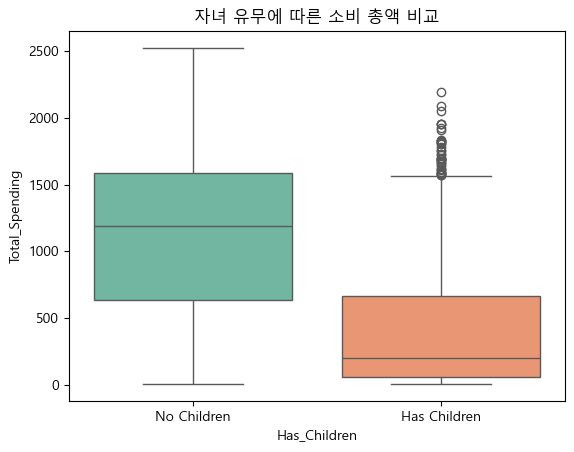

In [26]:
# TODO 3-2(c): 박스플롯 비교 시각화

fig, ax = plt.subplots(1,1)

sns.boxplot(data = df, x = 'Has_Children', y = 'Total_Spending', ax = ax, palette = 'Set2')

ax.set_xticklabels(['No Children', 'Has Children'])
ax.set_title('자녀 유무에 따른 소비 총액 비교')

plt.show()

### 문제 3-3. 대응표본 t-검정

같은 고객의 **와인 소비**(`MntWines`)와 **육류 소비**(`MntMeatProducts`)를 비교합니다.

- H₀: μ_Wine = μ_Meat (차이 = 0)
- H₁: μ_Wine ≠ μ_Meat

In [27]:
wines = df['MntWines']
meat = df['MntMeatProducts']

# TODO 3-3: 차이 계산 + 대응표본 t-검정 + Cohen's d + 결과 출력

diff_spend = wines - meat
print(f'차이 평균 : {diff_spend.mean():.2f}')
t_stat, diff_pval = stats.ttest_rel(wines, meat, alternative='two-sided')
print(f'검정 결과 p-value가 {diff_pval:.4f}로 유의수준 5%하에서 귀무가설을 기각한다.')

d = diff_spend.mean() / diff_spend.std(ddof = 1)
print(f'효과크기가 {d:.2f}로 중간 정도의 효과크기를 보인다.')

print(f'검정 결과와 효과크기를 고려했을 때, wines과 meat의 평균은 통계적으로 유의미한 차이를 보인다고 할 수 있다.')

차이 평균 : 137.14
검정 결과 p-value가 0.0000로 유의수준 5%하에서 귀무가설을 기각한다.
효과크기가 0.49로 중간 정도의 효과크기를 보인다.
검정 결과와 효과크기를 고려했을 때, wines과 meat의 평균은 통계적으로 유의미한 차이를 보인다고 할 수 있다.


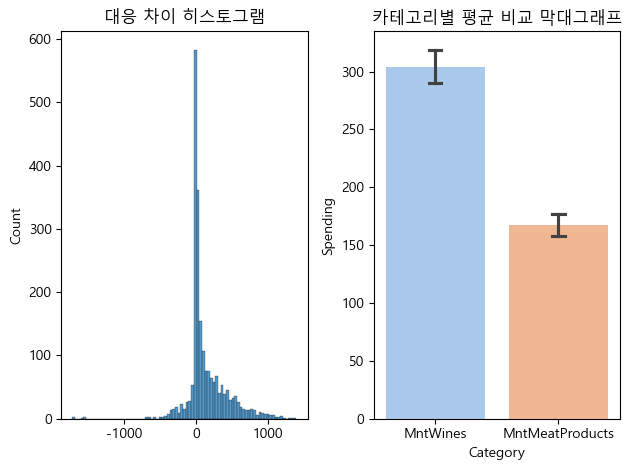

In [28]:
# TODO 3-3(b): (1) 대응 차이 히스토그램 (2) 카테고리별 평균 비교 막대그래프

fig, axs = plt.subplots(1,2)

sns.histplot(diff_spend, ax = axs[0])
axs[0].set_title('대응 차이 히스토그램')

category_df = df[['MntWines','MntMeatProducts']].melt(var_name = 'Category',value_name = 'Spending')

sns.barplot(data = category_df, x = 'Category',y = 'Spending', palette = 'pastel', ax = axs[1], errorbar = ('ci',95), capsize = 0.1)
axs[1].set_title('카테고리별 평균 비교 막대그래프')

plt.tight_layout()
plt.show()

### 문제 3-4. 검정력 분석

- **(a)** 문제 3-2의 효과 크기와 표본 크기를 사용하여 검정력(Power)을 계산하세요.
- **(b)** 작은 효과(d=0.2)를 탐지하기 위해 필요한 그룹당 표본 크기를 구하세요.

In [29]:
no_child = df[~df['Has_Children']]['Total_Spending']
yes_child = df[df['Has_Children']]['Total_Spending']

# TODO 3-2: Welch's t-검정 수행 + Cohen's d 계산 + 결과 출력
t_stat, p_val = stats.ttest_ind(no_child, yes_child, equal_var = False, alternative = 'two-sided')

print(f"Welch's t 검정 결과 : {p_val:.4f}로 유의수준 5%하에서 귀무가설을 기각한다.")

pg_result = pg.compute_effsize(no_child, yes_child, eftype = 'cohen')
print(f"Cohen's d 효과크기 : {pg_result.item():.2f}로 큰 효과크기를 보인다.")

print(f'두 결과를 고려했을 때, 자녀의 유무에 따른 고객의 소비의 평균은 큰 차이를 보인다고 할 수 있다.')
print()

power_analysis = TTestIndPower()

# TODO 3-4(a): 문제 3-2 기준 검정력 계산

n1 = len(no_child)
n2 = len(yes_child)

power_child = power_analysis.solve_power(
    effect_size = abs(pg_result.item()),
    nobs1 = n1,
    alpha = 0.05,
    alternative = 'two-sided',
    ratio = n2/n1
)

print(f"Welch's t-test 검정력 : {power_child}\n")

power_child_d_2 = power_analysis.solve_power(
    effect_size = 0.2,
    nobs1 = n1,
    alpha = 0.05,
    alternative = 'two-sided',
    ratio = n2/n1
)

print(f"Welch's t-test 검정력(d = 0.2) : {power_child_d_2:.4f}")

print('효과크기가 0.2인 경우에도 검정력이 0.9895로 매우 높게 측정된다.')
print('따라서, nan으로 표기되는 것은 0.999...를 계산하다 nan을 반환한 것으로 예상되며, 거의 1에 수렴하는 값이라고 해석하는 것이 좋아보인다.\n')

## TODO 3-4(b): 작은 효과(d=0.2) 탐지에 필요한 표본 크기 산정

print('각 집단을 동일하게 하여 표본을 다시 수집하려고 한다.')
required_n = power_analysis.solve_power(
    effect_size = 0.2,
    alpha = 0.05,
    power = 0.8,
    alternative = 'two-sided'
)

print(f'필요 표본 수 : {np.ceil(required_n) * 2}')

Welch's t 검정 결과 : 0.0000로 유의수준 5%하에서 귀무가설을 기각한다.
Cohen's d 효과크기 : 1.36로 큰 효과크기를 보인다.
두 결과를 고려했을 때, 자녀의 유무에 따른 고객의 소비의 평균은 큰 차이를 보인다고 할 수 있다.

Welch's t-test 검정력 : nan

Welch's t-test 검정력(d = 0.2) : 0.9895
효과크기가 0.2인 경우에도 검정력이 0.9895로 매우 높게 측정된다.
따라서, nan으로 표기되는 것은 0.999...를 계산하다 nan을 반환한 것으로 예상되며, 거의 1에 수렴하는 값이라고 해석하는 것이 좋아보인다.

각 집단을 동일하게 하여 표본을 다시 수집하려고 한다.
필요 표본 수 : 788.0


---
## Part 4: 고급 검정 — "교육, 결혼, 캠페인 반응의 관계는?"

정규성 검정을 바탕으로 적절한 검정 방법을 선택하고,
범주형 변수 간 관계를 분석합니다.

### 문제 4-1. 정규성 + 등분산 검정

Education_Group별 Total_Spending의 정규성을 Shapiro-Wilk 검정과 Q-Q Plot으로 확인하세요.
정규성이 기각되더라도, 표본이 충분히 크면(n ≥ 30) 중심극한정리(CLT)에 의해
ANOVA가 여전히 강건(robust)합니다. 각 그룹의 표본 크기도 함께 확인하세요.

⚠️ **등분산성 위반은 CLT와 무관합니다** — 표본이 아무리 커도 해결되지 않습니다.
Levene 검정으로 등분산 가정을 확인하고, 위반 시 Welch's ANOVA를 사용합니다.

In [30]:
edu_groups = ['Undergraduate', 'Graduate', 'Postgraduate']

# TODO 4-1(a): Shapiro-Wilk 검정 (각 그룹별)
for edu in edu_groups:
    group_df = df[df['Education_Group'] == edu]
    edu_stat, edu_pval = stats.shapiro(group_df['Total_Spending'])
    print(f'{edu} 그룹 정규성 검정 p-value : {edu_pval:.4f}')
    print(f'{edu} 표본 크기 : {len(group_df)}')

print('shapiro test 결과 정규성을 만족하지 않지만, 표본이 충분히 크기 때문에 평균의 분포가 정규성을 만족한다 판단하였다.')

# TODO 4-1(b): Levene 등분산 검정 → use_welch = True/False 설정
under = df.loc[df['Education_Group'] == edu_groups[0], 'Total_Spending']
grad = df.loc[df['Education_Group'] == edu_groups[1], 'Total_Spending']
post = df.loc[df['Education_Group'] == edu_groups[2], 'Total_Spending']

lev_stat, lev_pval = stats.levene(under, grad, post)
print(f'등분산성 검정 결과 p-value가 {lev_pval:.4f}로 등분산성을 만족하지 않는다.')

Undergraduate 그룹 정규성 검정 p-value : 0.0000
Undergraduate 표본 크기 : 255
Graduate 그룹 정규성 검정 p-value : 0.0000
Graduate 표본 크기 : 1126
Postgraduate 그룹 정규성 검정 p-value : 0.0000
Postgraduate 표본 크기 : 855
shapiro test 결과 정규성을 만족하지 않지만, 표본이 충분히 크기 때문에 평균의 분포가 정규성을 만족한다 판단하였다.
등분산성 검정 결과 p-value가 0.0000로 등분산성을 만족하지 않는다.


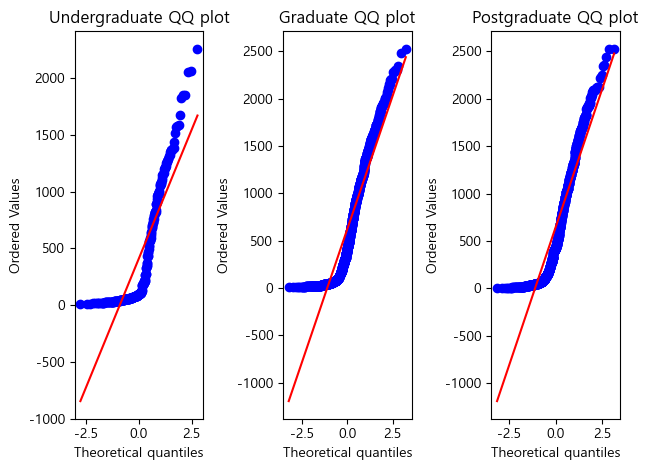

각 집단의 QQ plot 결과 정규성을 만족한다 보기 힘들다.
따라서, Welch's ANOVA를 활용함과 동시에 크루스칼 왈리스 검정을 함께 참고하여 검정을 수행하고자 한다.


In [31]:
# TODO 4-1(b): Q-Q Plot (1×3 서브플롯)

fig, axs = plt.subplots(1,3)

stats.probplot(under, dist = 'norm', plot = axs[0])
axs[0].set_title('Undergraduate QQ plot')

stats.probplot(grad, dist = 'norm', plot = axs[1])
axs[1].set_title('Graduate QQ plot')

stats.probplot(post, dist = 'norm', plot = axs[2])
axs[2].set_title('Postgraduate QQ plot')

plt.tight_layout()
plt.show()

print('각 집단의 QQ plot 결과 정규성을 만족한다 보기 힘들다.')
print("따라서, Welch's ANOVA를 활용함과 동시에 크루스칼 왈리스 검정을 함께 참고하여 검정을 수행하고자 한다.")

### 문제 4-2. ANOVA + 사후검정

문제 4-1의 정규성/등분산 검정 결과에 따라 적절한 검정을 수행합니다.

- 등분산 만족 → One-way ANOVA + **Tukey HSD** + Cohen's d
- 등분산 위반 → Welch's ANOVA + **Games-Howell** (`pg.pairwise_gameshowell()`) + Hedges' g
- 참고로 비모수 검정(Kruskal-Wallis)도 병행하여 결과의 일관성을 확인하세요.
- 효과 크기: η² + ω² (기준: 0.01 작은, 0.06 중간, 0.14 큰)
- 쌍별 효과 크기: Cohen's d / Hedges' g (기준: 0.2 미만 매우 작은, 0.2~0.5 작은, 0.5~0.8 중간, 0.8 이상 큰)

In [32]:
group_data = {g: df[df['Education_Group'] == g]['Total_Spending'].values for g in edu_groups}

# TODO 4-2(a): use_welch에 따라 ANOVA / Welch's ANOVA 수행 (Kruskal-Wallis도 병행)
res = pg.welch_anova(data = df, dv = 'Total_Spending', between = 'Education_Group')
print(f"Welch's ANOVA 검정 결과 p-value가 {res['p-unc'].values[0]:.4f}로 유의수준 5%하에서 귀무가설을 기각한다.")
print(f'따라서, 적어도 한 집단의 소비 평균이 다르다고 할 수 있다.')

# TODO 4-2(b): η² + ω² 계산 — ω² = (SS_between - (k-1)*MS_within) / (SS_total + MS_within)
eta_sq = res['np2'].values[0]

# 오메가용 pg.anova 계산
aov = pg.anova(data = df, dv = 'Total_Spending', between = 'Education_Group', detailed = True)

ss_between = aov['SS'].values[0]
df_between = aov['DF'].values[0]
ss_total = aov['SS'].values[0] + aov['SS'].values[1]
ms_within = aov['MS'].values[1]

omega_sq = (ss_between - (df_between * ms_within)) / (ss_total + ms_within)
print(f'에타 제곱 : {eta_sq:.4f}, 오메가 제곱 : {omega_sq:.4f}')
print(f'두 효과크기 모두 0.01 근방으로 작은 효과크기를 보인다.\n')

# 참고용 kruskal-wallis
print('참고용 검정 kruskal-wallis')
h_stat, kw_pval = stats.kruskal(under, grad, post)
print(f'크루스칼 왈리스 검정 p-value : {kw_pval:.4f}')

# 크루스칼 왈리스 효과크기
k3 = 3
N3 = len(under) + len(grad) + len(post)
eta_sq_h3 = (h_stat - k3 + 1) / (N3 - k3)
print(f'효과크기 : {eta_sq_h3:.4f}')

Welch's ANOVA 검정 결과 p-value가 0.0000로 유의수준 5%하에서 귀무가설을 기각한다.
따라서, 적어도 한 집단의 소비 평균이 다르다고 할 수 있다.
에타 제곱 : 0.0137, 오메가 제곱 : 0.0128
두 효과크기 모두 0.01 근방으로 작은 효과크기를 보인다.

참고용 검정 kruskal-wallis
크루스칼 왈리스 검정 p-value : 0.0000
효과크기 : 0.0155


In [33]:
# TODO 4-2(c): 사후검정 수행 + 해석 + 쌍별 효과크기
# 등분산 만족 → Tukey HSD + Cohen's d
# 등분산 위반 → Games-Howell (pg.pairwise_gameshowell) + Hedges' g

gh2 = pg.pairwise_gameshowell(dv = 'Total_Spending', between = 'Education_Group', data = df)
display(gh2)

print('검정 결과 Undergraduate와 Graduate, Undergraduate와 Postgraduate간 차이가 존재한다.')
print('소비의 평균 크기는 under < grad <= post로 해석할 수 있다.')
print('유의한 차이를 보이는 집단의 효과크기를 보았을 때, 중간 정도의 효과크기를 보인다.')
print('종합적으로 보았을 때, 소비의 차이는 undergraduate와 다른 두 집단의 차이가 통계적으로 유의미하다고 결론 지을 수 있다.')

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,Graduate,Postgraduate,620.394316,644.791813,-24.397497,27.691976,-0.881031,1808.339544,6.523632e-01,-0.040121
1,Graduate,Undergraduate,620.394316,412.254902,208.139414,36.852786,5.647861,425.032927,8.920656e-08,0.355688
2,Postgraduate,Undergraduate,644.791813,412.254902,232.536911,38.554847,6.031328,492.811108,9.577128e-09,0.389636


검정 결과 Undergraduate와 Graduate, Undergraduate와 Postgraduate간 차이가 존재한다.
소비의 평균 크기는 under < grad <= post로 해석할 수 있다.
유의한 차이를 보이는 집단의 효과크기를 보았을 때, 중간 정도의 효과크기를 보인다.
종합적으로 보았을 때, 소비의 차이는 undergraduate와 다른 두 집단의 차이가 통계적으로 유의미하다고 결론 지을 수 있다.


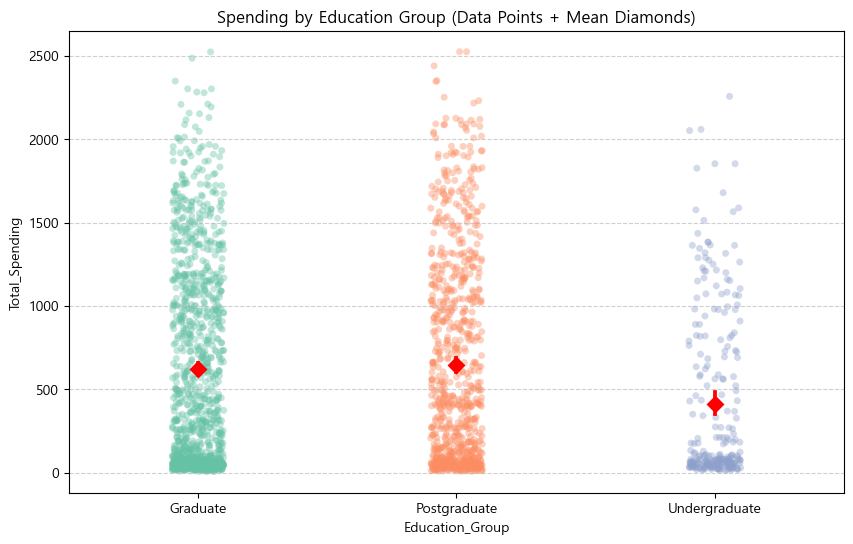

In [34]:
# TODO 4-2(d): 시각화 — 그룹별 개별 데이터 산점도 + 평균 다이아몬드

plt.figure(figsize = (10,6))

# stripplot이 맞나요...? 의도가 뭘까...?
sns.stripplot(data = df, x = 'Education_Group', y = 'Total_Spending',
            palette = 'Set2', alpha = 0.4, jitter = True, zorder = 1)

# 평균 다이아몬드 얹기
sns.pointplot(data = df, x = 'Education_Group', y = 'Total_Spending',
            color = 'red', markers = 'D', linestyles = '', zorder = 2)


# AI 사용
plt.title('Spending by Education Group (Data Points + Mean Diamonds)')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

### 문제 4-3. 카이제곱 독립성 검정

**가설**: 결혼 상태(Marital_Group)와 캠페인 반응(Campaign_Response)은 독립인가?

- H₀: Marital_Group과 Campaign_Response는 독립이다.
- H₁: 두 변수는 독립이 아니다.

- 효과크기: φ (phi) = √(χ² / n) (기준: 0.1 작은, 0.3 중간, 0.5 큰)
- 오즈비(Odds Ratio): OR = (a×d) / (b×c), 95% CI = exp(ln(OR) ± 1.96 × SE)

> ⚠️ Cochran 규칙: 기대빈도 < 5인 셀이 전체의 20% 초과 시 Fisher 정확검정 필요

In [35]:
crosstab_no_margin = pd.crosstab(df['Marital_Group'], df['Campaign_Response'])
# TODO 4-3(a): 카이제곱 검정 수행 + Cochran 규칙 확인
display(crosstab_no_margin)
print('모든 셀 기대빈도 5 이상, 코크란 룰 만족')

chi2_stat, chi_pval, chi_dof, expected = stats.chi2_contingency(crosstab_no_margin)

print(f'독립성 검정 결과 p-value : {chi_pval:.4f}로 유의수준 5%하에서 귀무가설을 기각한다.')
print(f'따라서, 두 변수는 독립이 아니라고 할 수 있다.')

# TODO 4-3(b): φ (phi) 계산
phi = np.sqrt(chi2_stat / crosstab_no_margin.values.sum())
print(f'효과크기가 {phi:.3f}로 작은 효과크기를 보인다.')

# TODO 4-3(c): 오즈비(Odds Ratio) + 95% CI 계산
a = crosstab_no_margin.iloc[0,1] # Single True
b = crosstab_no_margin.iloc[0,0] # Single False
c = crosstab_no_margin.iloc[1,1] # Marital True
d = crosstab_no_margin.iloc[1,0] # Marital False

odd_ratio = (a/b) / (c/d)
print(f'odd_ratio : {odd_ratio:.2f}로 싱글 그룹의 오즈가 결혼 그룹의 오즈의 1.35배이다.')

log_or = np.log(odd_ratio)
se = np.sqrt(1/a + 1/b + 1/c + 1/d)

ci_low = np.exp(log_or - 1.96 * se)
ci_upp = np.exp(log_or + 1.96 * se)
print(f'오즈비 신뢰구간 : [{ci_low:.3f}, {ci_upp:.3f}]')

print('종합적으로 비교했을 때, 독립이라고 할 수 있다.')
print('효과크기가 0.06으로 작은 효과크기를 보이지만, 오즈비가 1.35이고 신뢰구간이 1을 포함하지 않기 때문에')
print('고려할 가치가 있는 변수로 판단된다.')

Campaign_Response,False,True
Marital_Group,,
Single,547,247
Together,1081,361


모든 셀 기대빈도 5 이상, 코크란 룰 만족
독립성 검정 결과 p-value : 0.0024로 유의수준 5%하에서 귀무가설을 기각한다.
따라서, 두 변수는 독립이 아니라고 할 수 있다.
효과크기가 0.064로 작은 효과크기를 보인다.
odd_ratio : 1.35로 싱글 그룹의 오즈가 결혼 그룹의 오즈의 1.35배이다.
오즈비 신뢰구간 : [1.116, 1.638]
종합적으로 비교했을 때, 독립이라고 할 수 있다.
효과크기가 0.06으로 작은 효과크기를 보이지만, 오즈비가 1.35이고 신뢰구간이 1을 포함하지 않기 때문에
고려할 가치가 있는 변수로 판단된다.


표준화 잔차의 절대값이 2인 항목이 single인 경우 응답한 경우이다.
따라서, 싱글의 캠페인에 대해 응답을 기대보다 많이 했다고 볼 수 있다.


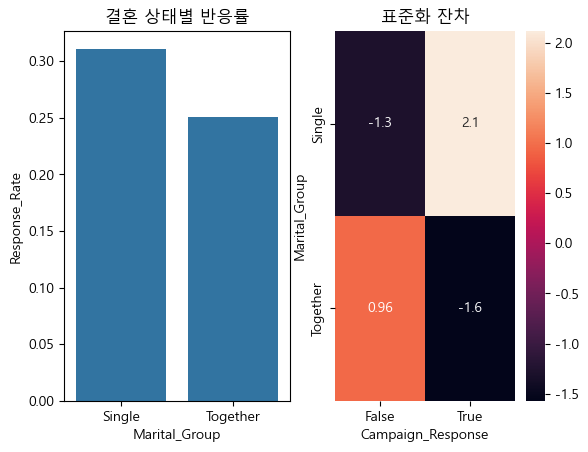

In [36]:
# TODO 4-3(d): (1) 결혼 상태별 반응률 막대그래프 (2) 표준화 잔차 히트맵

fig, axs = plt.subplots(1,2)

# 반응률 계산
response_rate = crosstab_no_margin.apply(lambda x: x / x.sum(), axis=1).loc[:,True]
response_rate_df = response_rate.reset_index()
response_rate_df.columns = ['Marital_Group','Response_Rate']

# 표준화 잔차 계산
observed = crosstab_no_margin.values
standardized_residuals = (observed - expected) / np.sqrt(expected)

sns.barplot(data = response_rate_df, x = 'Marital_Group', y = 'Response_Rate', ax = axs[0])
axs[0].set_title('결혼 상태별 반응률')

sns.heatmap(standardized_residuals, annot = True, ax = axs[1])
axs[1].set_title('표준화 잔차')
axs[1].set_xlabel('Campaign_Response')
axs[1].set_ylabel('Marital_Group')
axs[1].set_xticklabels(crosstab_no_margin.columns)
axs[1].set_yticklabels(crosstab_no_margin.index)

print('표준화 잔차의 절대값이 2인 항목이 single인 경우 응답한 경우이다.')
print('따라서, 싱글의 캠페인에 대해 응답을 기대보다 많이 했다고 볼 수 있다.')

### 문제 4-4. 적합도 검정

3개 구매 채널(Web, Catalog, Store)의 총 구매 비율이 균등하게 분포하는지 검정합니다.

- H₀: 세 채널의 구매 비율이 동일하다 (1/3 : 1/3 : 1/3)
- H₁: 세 채널의 구매 비율이 동일하지 않다

Cohen's w = √(Σ(p_obs - p_exp)² / p_exp)

In [37]:
channel_totals = df[purchase_cols].sum()
channel_names = ['Web', 'Catalog', 'Store']
observed = channel_totals.values

# TODO 4-4(a): 기대빈도(균등) 계산 + 적합도 검정
expected = np.array([sum(observed) / 3] * 3)
chi2_stat, p_val = stats.chisquare(observed, expected)
print(f'검정 결과 p-value가 {p_val:.4f}로 유의수준 5%하에서 귀무가설을 기각한다.')

# TODO 4-4(b): Cohen's w 계산
cohens_w = np.sqrt(chi2_stat / observed.sum())
print(f'효과크기가 {cohens_w:.4f}로 중간 정도의 효과를 보인다.')

print(f'따라서, 세 채널의 구매 비율이 동일하지 않다고 결론 지을 수 있다.')

검정 결과 p-value가 0.0000로 유의수준 5%하에서 귀무가설을 기각한다.
효과크기가 0.3062로 중간 정도의 효과를 보인다.
따라서, 세 채널의 구매 비율이 동일하지 않다고 결론 지을 수 있다.


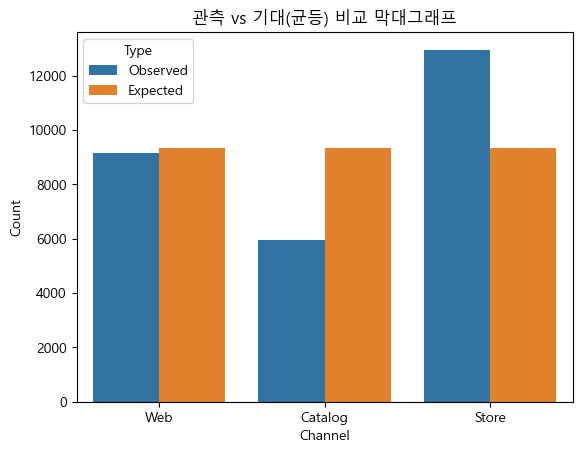

In [38]:
# TODO 4-4(c): 관측 vs 기대(균등) 비교 막대그래프

plot_df = pd.DataFrame(
    {
        'Channel' : channel_names * 2,
        'Count' : np.concatenate([observed, expected]),
        'Type' : ['Observed'] * 3 + ['Expected'] * 3
    }
)

sns.barplot(data = plot_df, x = 'Channel', y = 'Count', hue = 'Type')
plt.title('관측 vs 기대(균등) 비교 막대그래프')
plt.show()

---
## Part 5: 상관분석 / 비율 비교 — "변수 간 관계를 파악하고, 캠페인 효과를 검증할 수 있는가?"

변수 간 상관관계를 분석하고, A/B 테스트로 캠페인 효과를 검증합니다.

### 문제 5-1. 상관분석

6개 변수의 Pearson/Spearman 상관계수를 계산하고 히트맵으로 시각화하세요.
주요 변수 쌍에 대해 유의성 검정도 수행합니다.

In [39]:
corr_vars = ['Income', 'Age', 'Total_Spending', 'Total_Purchases',
            'NumWebVisitsMonth', 'Recency']

# TODO 5-1(a): Pearson/Spearman 상관행렬 계산

pearson_mat = df[corr_vars].corr()
spearman_mat = df[corr_vars].corr(method = 'spearman')

# TODO 5-1(b): 주요 상관계수 쌍의 유의성 검정 (stats.pearsonr)
print('대부분의 변수의 상관성이 높았기 때문에, 의미없는 상관관계를 가지는 변수만 확인')
pearson_result = pg.pairwise_corr(df[corr_vars], method = 'pearson')
display(pearson_result[pearson_result['p-unc'] > 0.05])

spearman_result = pg.pairwise_corr(df[corr_vars], method = 'spearman')
display(spearman_result[spearman_result['p-unc'] > 0.05])

print('Recency는 모든 변수와 선형적 관계나 단조 관계를 가진다고 보기 힘들다.')

대부분의 변수의 상관성이 높았기 때문에, 의미없는 상관관계를 가지는 변수만 확인


,X,Y,method,alternative,n,r,CI95%,p-unc,BF10,power
4,Income,Recency,pearson,two-sided,2236,0.007829,"[-0.03, 0.05]",0.711370,0.028,0.065822
8,Age,Recency,pearson,two-sided,2236,0.019396,"[-0.02, 0.06]",0.359267,0.04,0.150451
11,Total_Spending,Recency,pearson,two-sided,2236,0.020842,"[-0.02, 0.06]",0.324566,0.043,0.166452
13,Total_Purchases,Recency,pearson,two-sided,2236,0.006426,"[-0.04, 0.05]",0.761377,0.028,0.060624
14,NumWebVisitsMonth,Recency,pearson,two-sided,2236,-0.021850,"[-0.06, 0.02]",0.301720,0.045,0.178314


,X,Y,method,alternative,n,r,CI95%,p-unc,power
4,Income,Recency,spearman,two-sided,2236,0.009743,"[-0.03, 0.05]",0.645175,0.074621
8,Age,Recency,spearman,two-sided,2236,0.020109,"[-0.02, 0.06]",0.341883,0.158186
11,Total_Spending,Recency,spearman,two-sided,2236,0.019979,"[-0.02, 0.06]",0.345008,0.156756
13,Total_Purchases,Recency,spearman,two-sided,2236,0.011726,"[-0.03, 0.05]",0.579465,0.085857
14,NumWebVisitsMonth,Recency,spearman,two-sided,2236,-0.022259,"[-0.06, 0.02]",0.292756,0.183296


Recency는 모든 변수와 선형적 관계나 단조 관계를 가진다고 보기 힘들다.


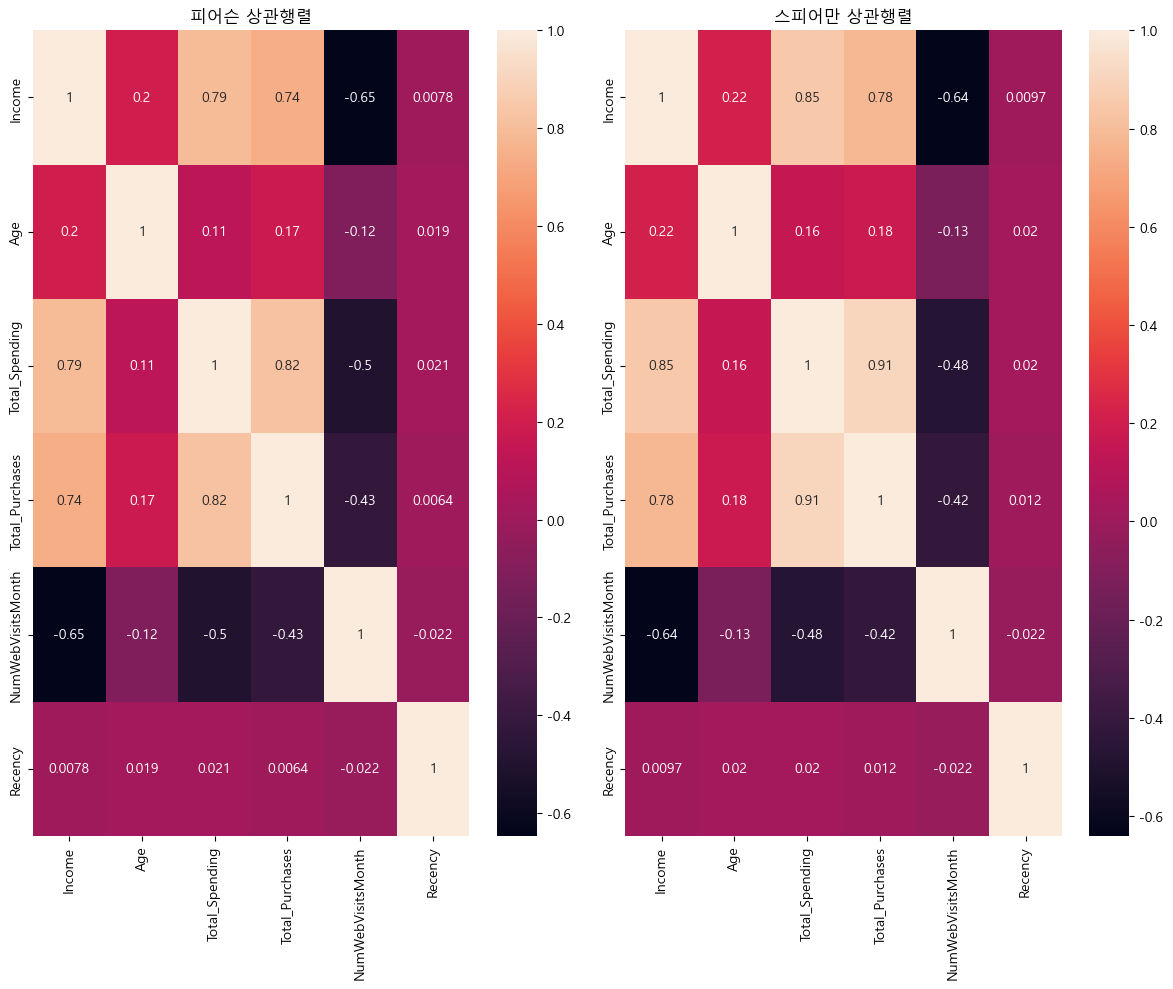

In [40]:
# TODO 5-1(c): 상관행렬 히트맵 (Pearson + Spearman, 1×2 서브플롯)

fig, axs = plt.subplots(1,2,figsize = (12,10))

sns.heatmap(pearson_mat, annot = True, ax = axs[0])
axs[0].set_title('피어슨 상관행렬')

sns.heatmap(spearman_mat, annot = True, ax = axs[1])
axs[1].set_title('스피어만 상관행렬')

plt.tight_layout()
plt.show()

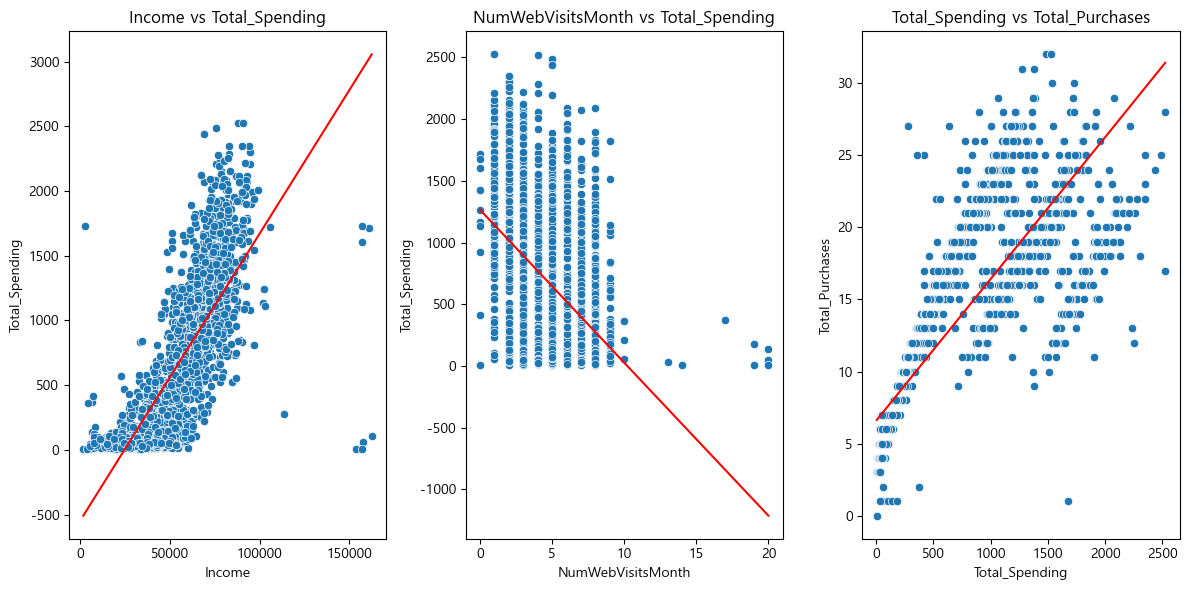

In [41]:
# TODO 5-1(d): 주요 변수 쌍 산점도 + 추세선 (1×3 서브플롯)
# 대상: (Income, Total_Spending), (NumWebVisitsMonth, Total_Spending), (Total_Spending, Total_Purchases)
# np.polyfit()으로 1차 추세선을 그리세요

fig, axes = plt.subplots(1,3, figsize = (12,6))

for i, (col1, col2) in enumerate([('Income', 'Total_Spending'), ('NumWebVisitsMonth', 'Total_Spending'), ('Total_Spending', 'Total_Purchases')]):
    sns.scatterplot(data = df, x = col1, y = col2, ax = axes[i])
    z1 = np.polyfit(df[col1], df[col2], 1)
    x_line = np.linspace(df[col1].min(), df[col1].max(), 100)
    axes[i].plot(x_line, np.poly1d(z1)(x_line), color = 'red')
    axes[i].set_xlabel(f'{col1}')
    axes[i].set_ylabel(f'{col2}')
    axes[i].set_title(f'{col1} vs {col2}')

plt.tight_layout()
plt.show()

### 문제 5-2. 두 그룹 비율 비교 (관찰 연구)

이전 캠페인 반응 경험 유무에 따라 마지막 캠페인(Response) 수락률에 차이가 있는지 검증합니다.

- **Group A**: AcceptedCmp1~5 합계 = 0 (이전 캠페인 무반응)
- **Group B**: AcceptedCmp1~5 합계 ≥ 1 (이전 캠페인 반응 경험)
- **지표**: Response (마지막 캠페인 수락률)
- **검정 방법**: z-비율검정 + Cohen's h + Wilson 신뢰구간

> **주의**: 이 분석은 A/B 테스트가 **아닙니다**. \
> A/B 테스트는 연구자가 참가자를 **무작위로 배정** (Random Assignment)하는 실험입니다. \
> 여기서는 고객이 과거 행동에 의해 스스로 그룹에 배정되었으므로 **관찰 연구**이며, \
> 인과관계를 주장할 수 없습니다.

In [42]:
from statsmodels.stats.proportion import proportions_ztest

cmp_cols = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5']
df['Prior_Response'] = df[cmp_cols].sum(axis=1)

group_a = df[df['Prior_Response'] == 0]
group_b = df[df['Prior_Response'] >= 1]

n_a, n_b = len(group_a), len(group_b)
conv_a = group_a['Response'].sum()
conv_b = group_b['Response'].sum()
rate_a = conv_a / n_a
rate_b = conv_b / n_b


count = np.array([conv_a, conv_b])
nobs = np.array([n_a, n_b])

print(n_a, n_b)
print(conv_a, conv_b)
print(rate_a, rate_b)

# TODO 5-2(a): z-비율검정
z_stat, z_p = proportions_ztest(count, nobs, alternative = 'two-sided')
print(f'검정 결과 p-value가 {z_p:.4f}로 유의수준 5%하에서 귀무가설을 기각한다.')

# TODO 5-2(b): Cohen's h 효과 크기
h = proportion_effectsize(rate_a, rate_b)
print(f'효과크기의 절대값이 {abs(h):.4f}로 효과크기가 크다고 할 수 있다.')
# TODO 5-2(c): Wilson 신뢰구간
ci_a = proportion_confint(conv_a, n_a, method = 'wilson')
ci_b = proportion_confint(conv_b, n_b, method = 'wilson')

print(f'이전 캠페인 무반응에 대한 응답률 신뢰구간 : [{ci_a[0]:.4f}, {ci_a[1]:.4f}]')
print(f'이전 캠페인 반응에 대한 응답률 신뢰구간 : [{ci_b[0]:.4f}, {ci_b[1]:.4f}]')

print(f'종합적인 결론으로 통계적으로 유의한 차이가 있다고 할 수 있다.')

1774 462
146 188
0.08229988726042842 0.4069264069264069
검정 결과 p-value가 0.0000로 유의수준 5%하에서 귀무가설을 기각한다.
효과크기의 절대값이 0.8016로 효과크기가 크다고 할 수 있다.
이전 캠페인 무반응에 대한 응답률 신뢰구간 : [0.0704, 0.0960]
이전 캠페인 반응에 대한 응답률 신뢰구간 : [0.3631, 0.4523]
종합적인 결론으로 통계적으로 유의한 차이가 있다고 할 수 있다.


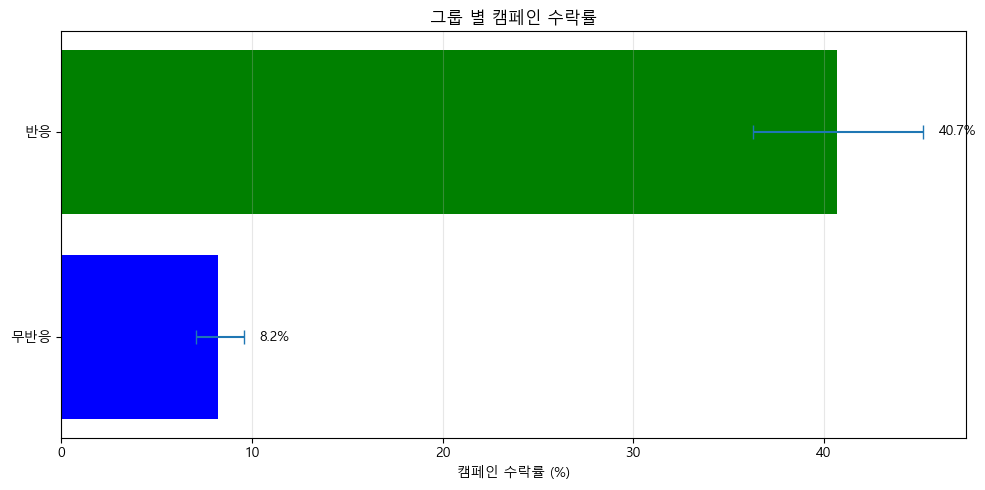

In [43]:
# TODO 5-2(d): 수락률 비교 시각화 (CI 오차막대 포함)

labels = ['무반응', '반응']
y_pos = [0,1]
rates_pct = [rate_a * 100, rate_b * 100]

xerr_low = [rate_a * 100 - ci_a[0] * 100, rate_b * 100 - ci_b[0] * 100]
xerr_high = [ci_a[1] * 100 - rate_a * 100, ci_b[1] * 100 - rate_b * 100]
x_errors = [xerr_low, xerr_high]

fig, ax = plt.subplots(figsize = (10,5))

bar_colors = ['blue','green']
ax.barh(y_pos, rates_pct, color = bar_colors)
ax.errorbar(rates_pct, y_pos, xerr = x_errors, fmt = 'none', capsize = 5)

ax.set_yticks(y_pos)
ax.set_yticklabels(labels)
ax.set_xlabel('캠페인 수락률 (%)')
ax.set_title('그룹 별 캠페인 수락률')
ax.grid(axis = 'x', alpha = 0.3)

for i,v in enumerate(rates_pct):
    ax.text(v + xerr_high[i] + 0.8, i, f'{v:.1f}%', va = 'center')

plt.tight_layout()
plt.show()

> ⚠️ **이 분석이 A/B 테스트가 아닌 이유**
>
> A/B 테스트의 본질은 '무작위 배정(Random Assignment)'입니다.
>
> - **A/B 테스트**: 연구자가 참가자를 무작위로 배정 → 인과관계 추론 가능
> - **이 분석**: 고객의 과거 행동으로 그룹이 결정 → 관찰 연구, 인과관계 주장 불가
>
> → 인과관계를 검증하려면 무작위 배정 실험(RCT)을 설계해야 합니다. (문제 5-3)

### 문제 5-3. 진정한 A/B 테스트 설계

새로운 캠페인이 기존 수락률 대비 **2%p** 개선을 가져올 수 있는지 탐지하기 위한
최소 표본 크기를 산정하세요. (α=0.05, Power=0.80)

In [44]:
baseline_rate = df['Response'].mean()
target_rate = baseline_rate + 0.02

# TODO 5-3(a): Cohen's h 계산
h = abs(proportion_effectsize(target_rate, baseline_rate))
print(f'효과크기 : {h:.2f}')

# TODO 5-3(b): NormalIndPower()로 필요 표본 크기 산정 (α=0.05, Power=0.80, 단측)
power_analysis = NormalIndPower()
sample_size = power_analysis.solve_power(
    effect_size=h,
    alpha=0.05,
    power=0.8,
    alternative='larger'
)
sample_size = int(np.ceil(sample_size))

print(f"\n[1] 실험 설계 (단측검정)")
print("-" * 40)
print(f"  기존 수락률 (p₀): {baseline_rate:.0%}")
print(f"  목표 수락률 (p₁): {target_rate:.0%}")
print(f"  MDE (최소 탐지 효과): {target_rate - baseline_rate:.0%}p")

print(f"  효과크기 (Cohen's h): {h:.4f}")
sample_size = int(np.ceil(sample_size))
print(f"\n  집단당 필요 표본 크기: {sample_size:,}명")
print(f"  총 필요 표본 크기: {sample_size * 2:,}명")

효과크기 : 0.05

[1] 실험 설계 (단측검정)
----------------------------------------
  기존 수락률 (p₀): 15%
  목표 수락률 (p₁): 17%
  MDE (최소 탐지 효과): 2%p
  효과크기 (Cohen's h): 0.0547

  집단당 필요 표본 크기: 4,138명
  총 필요 표본 크기: 8,276명


---
## Challenge: 종합 분석 보고서

지금까지의 분석을 종합하여 FreshCart 마케팅팀에 제출할 보고서를 작성합니다.

### Challenge 1. 고객 그룹별 특성 분석

`Income_Group` × `Has_Children` 6개 조합에 대해 다음을 포함하는 종합 분석표를 작성하세요:

- 고객 수, 평균 소득, 평균/중앙값 소비, 평균 구매 수, 캠페인 반응률, 웹 방문 수
- 그룹 비교 시각화 (1×3 서브플롯: 평균 소비, 반응률, 고객 수)

In [45]:
# TODO C-1: 고객 그룹별 특성 분석 종합표 + 시각화

# ID, Income, Total_Spending, Total_Purchases, Response, NumWebVisitsMonth
# 고객수, 평균 소득, 평균 소비, 중앙값 소비, 평균 구매수, 반응률, 평균 웹 방문 수

summary = df.groupby(['Income_Group', 'Has_Children']).agg({
    'ID' : 'count',
    'Income' : 'mean',
    'Total_Spending' : ['mean','median'],
    'Total_Purchases' : 'mean',
    'Response' : 'mean',
    'NumWebVisitsMonth' : 'mean'
})

summary.columns = [f'{col[0]}_{col[1]}' if col[1] else col[0] for col in summary.columns]

summary = summary.reset_index().rename(columns = {
    'ID_count' : '고객 수',
    'Income_mean' : '평균 소득',
    'Total_Spending_mean' : '평균 소비',
    'Total_Spending_median' : '중앙값 소비',
    'Total_Purchases_mean' : '평균 구매수',
    'Response_mean' : '반응률',
    'NumWebVisitsMonth_mean' : '평균 웹 방문 수'
})

display(summary)

,Income_Group,Has_Children,고객 수,평균 소득,평균 소비,중앙값 소비,평균 구매수,반응률,평균 웹 방문 수
0,Low,False,115,24380.243478,145.008696,73.0,6.400000,0.104348,6.930435
1,Low,True,631,29172.879556,86.686212,54.0,5.670365,0.117274,6.901743
2,Mid,False,80,52209.631250,721.237500,653.0,15.362500,0.187500,4.675000
3,Mid,True,665,51466.093985,426.254135,368.0,12.338346,0.090226,5.869173
4,High,False,442,78697.963801,1424.024887,1383.0,19.219457,0.321267,2.366516
5,High,True,303,71841.607261,1033.115512,1005.0,19.178218,0.102310,4.679868


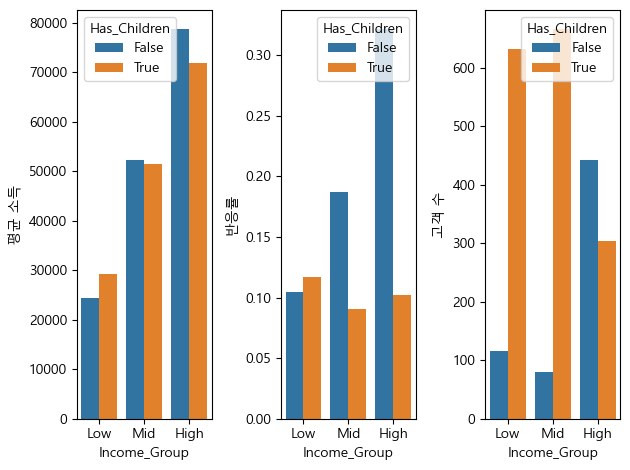

In [46]:
fig, axs = plt.subplots(1,3)

# 평균 소비, 반응률, 고객 수
columns = ['평균 소득','반응률','고객 수']

for i, col in enumerate(columns):
    sns.barplot(data = summary, x = 'Income_Group', y = col, hue = 'Has_Children', ax = axs[i])

plt.tight_layout()
plt.show()

### Challenge 2. 비즈니스 제안서

분석 결과를 종합하여 다음을 포함하는 제안서를 작성하세요:

1. **타겟 고객**: 어떤 그룹를 우선 집중 공략해야 하는가? (근거 포함)
2. **채널 전략**: 소득 그룹별 최적 마케팅 채널은?
3. **기대 효과**: 집중 공략 기반 예상 개선 효과
4. **한계점**: 분석의 한계와 추가 필요 데이터

In [47]:
# TODO C-2: 비즈니스 제안서 작성

print('1. 타겟 고객: 어떤 그룹을 우선 집중 공략해야 하는가?')
print('고소득 군의 미자녀를 우선적으로 타겟 고객으로 삼아야한다.')
print('고소득 군의 미자녀의 평균 소비량이 높고, 고객수도 400명 가량에 캠페인에 대한 반응률도 가장 높다.')
print('또한, 소득과 소비가 강한 양의 상관관계를 보였고, 통계적으로도 유의하였다.')
print('따라서, 이 그룹을 타겟으로 하여 선호 품목을 파악해 캠페인을 진행한다면, 실질적인 매출 증가로 이어질 가능성이 높다.')
print('-' * 50)

print('2. 소득 그룹별 최적 마케팅 채널은?')
print('앞서 적합도 검정을 통해 오프라인 매장의 구매 횟수가 기대빈도에 비해 유의미하게 높은 차이를 보이는 것을 확인했다.')
print('또한, 카탈로그는 기대 빈도 대비 낮은 구매 횟수를 기록했으므로, 카탈로그로 마케팅을 진행하는 것은 기대 효과가 낮을 것으로 예상된다.')
print('또한, 표준화 잔차를 통해 싱글인 경우에 반응률이 높은 것을 알 수 있었고,')
print('종합 분석표에서 평균 웹 방문수가 타겟 그룹이 낮은 것을 알 수 있다.')
print('따라서, 추후 2차 분석을 통해 확인해야 하지만 우선 타겟 그룹은 오프라인 매장의 마케팅을,')
print('나머지 군은 반응률은 낮지만 평균 웹 방문수가 높은 것을 고려해 웹을 메인으로, 오프라인 마케팅을 서브 전략으로 병행하여 마케팅을 진행해야 한다.')
print('-' * 50)

print('3. 기대 효과: 집중 공략 기반 예상 개선 효과')
print('고소득 미자녀 군의 고객 수는 전체 고객수의 20% 가량이다.')
print('또한, 펼치는 캠페인의 평균 반응률이 30%를 고려했을 때, 니즈를 파악하여 마케팅을 펼친다면 빠르게 매출의 증대로 이어질 것이라고 예상된다.')
print('그리고 앞서 정규분포를 기반으로 VIP 기준을 87171 정도로 설정했는데, 평균 소득이 약 78697$임을 고려했을 때,')
print('VIP 전용 고객들을 대상으로 프리미엄 오프라인 마케팅 캠페인을 진행한다면 효과적일 것으로 예상된다.')
print('또한, 추가적으로 와인의 평균 소비가 육류의 평균 소비와 통계적으로 유의미한 차이가 났음을 고려하면,')
print('먼저 와인에 대해서 캠페인을 진행하는 것도 한 가지 전략이라고 할 수 있다.')
print('-' * 50)

print('4. 한계점: 분석의 한계와 추가 필요 데이터')
print('우선 데이터 전반에 대해 분석을 진행하다보니, 좀 더 세부적으로 나누어 특정 그룹들에 대한 추가적인 분석이 필요하다.')
print('또한, 이전에 진행한 캠페인이 주로 어떤 채널을 통해 진행된지에 대한 세부적인 데이터가 존재하지 않으므로,')
print('각 캠페인 별로 어떤 채널로 진행하였는지, 각 채널 별 기대 반응률과 수익성이 반영된 데이터를 수집하여')
print('각 캠페인 전략에 대해 좀 더 직접적인 분석과 실패 원인들을 파악해, 캠페인 전략을 다시 수립해야 한다.')

1. 타겟 고객: 어떤 그룹을 우선 집중 공략해야 하는가?
고소득 군의 미자녀를 우선적으로 타겟 고객으로 삼아야한다.
고소득 군의 미자녀의 평균 소비량이 높고, 고객수도 400명 가량에 캠페인에 대한 반응률도 가장 높다.
또한, 소득과 소비가 강한 양의 상관관계를 보였고, 통계적으로도 유의하였다.
따라서, 이 그룹을 타겟으로 하여 선호 품목을 파악해 캠페인을 진행한다면, 실질적인 매출 증가로 이어질 가능성이 높다.
--------------------------------------------------
2. 소득 그룹별 최적 마케팅 채널은?
앞서 적합도 검정을 통해 오프라인 매장의 구매 횟수가 기대빈도에 비해 유의미하게 높은 차이를 보이는 것을 확인했다.
또한, 카탈로그는 기대 빈도 대비 낮은 구매 횟수를 기록했으므로, 카탈로그로 마케팅을 진행하는 것은 기대 효과가 낮을 것으로 예상된다.
또한, 표준화 잔차를 통해 싱글인 경우에 반응률이 높은 것을 알 수 있었고,
종합 분석표에서 평균 웹 방문수가 타겟 그룹이 낮은 것을 알 수 있다.
따라서, 추후 2차 분석을 통해 확인해야 하지만 우선 타겟 그룹은 오프라인 매장의 마케팅을,
나머지 군은 반응률은 낮지만 평균 웹 방문수가 높은 것을 고려해 웹을 메인으로, 오프라인 마케팅을 서브 전략으로 병행하여 마케팅을 진행해야 한다.
--------------------------------------------------
3. 기대 효과: 집중 공략 기반 예상 개선 효과
고소득 미자녀 군의 고객 수는 전체 고객수의 20% 가량이다.
또한, 펼치는 캠페인의 평균 반응률이 30%를 고려했을 때, 니즈를 파악하여 마케팅을 펼친다면 빠르게 매출의 증대로 이어질 것이라고 예상된다.
그리고 앞서 정규분포를 기반으로 VIP 기준을 87171 정도로 설정했는데, 평균 소득이 약 78697$임을 고려했을 때,
VIP 전용 고객들을 대상으로 프리미엄 오프라인 마케팅 캠페인을 진행한다면 효과적일 것으로 예상된다.
또한, 추가적으로 와인의 평

---
## 수고하셨습니다!

설날 연휴 따뜻하고 복 가득한 시간 보내요! 💛